In [2]:
# This cell will help us plot the convergence of the model in real time
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 57 kB 1.8 MB/s eta 0:00:011
     |████████████████████████████████| 537 kB 13.6 MB/s eta 0:00:01
Populating the interactive namespace from numpy and matplotlib


In [4]:
# This cell performs all the imports that we will need in this coursework
from sklearn.metrics import accuracy_score # this allows us to evaluate our model at every iteration
from sklearn.model_selection import StratifiedShuffleSplit # this allows us to create a random validation split

# These imports help plot the convergence and create the confusion matrix
from livelossplot import PlotLosses
from pycm import *

# These imports help us create models and datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# This allows me to create my own custom dataset
from torch.utils.data import Dataset 

# This allows me to import pretrained models for transfer learning
import torchvision.models as torchmodels

# This allows me to do a number of transforms for data augmentation later on
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, RandomApply, RandomChoice, RandomRotation, RandomCrop, RandomHorizontalFlip, RandomAffine, ToPILImage

# This functions sets up all our random seeds so that the results will be reproducible
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

# Enable hardware acceleration
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


In [10]:
my_data = ImageFolder("../input/acse-miniproject/train/")

In [11]:
# First import resnet from models, it is pretrained on imagenet and we will keep those weights to detect features
resnet = torchmodels.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [12]:
# Freeze the weights in the earlier layers:
for param in resnet.parameters():
    param.requires_grad = False

# print and check what the last FC layer is: 
print(resnet)

# Get how many features it has as input
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10) # change number of output classes

# unfreeze the last layer so it learns on our dataset
for param in resnet.fc.parameters():
  param.requires_grad = True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

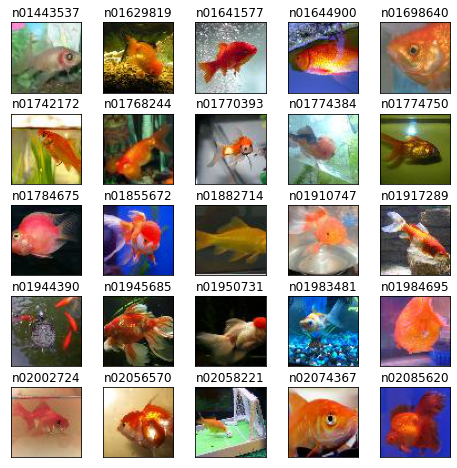

In [16]:
fig, axarr = plt.subplots(5, 5, figsize=(8, 8))
for ax, i in zip(axarr.flatten(), range(25)):
  ax.imshow(my_data[i][0])
  ax.set_title(my_data.classes[i])
  ax.get_xaxis().set_visible(False) # turn off the axes to improve visibility
  ax.get_yaxis().set_visible(False) # since the axes do not provide useful info
plt.subplots_adjust(hspace=0.3) # increase spaces between the plots to improve visibility
plt.show()